# Text analysis on Customer Reviews

The aim of this project is to analyse the customer reviews on British airways. These reviews have been scrapped from the website https://www.airlinequality.com/airline-reviews/british-airways. Using this data and the BeautifulSoup module analysis is performed using the scikit-learn modules, matplotlib and seaborn for visualisation. 

## Web scrapping 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#to perform web scraping 
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup

#to perform text analysis 
from urllib.parse import urlparse

#create a corpus of the customer reviews
#not removing stop words 
#from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [2]:
#example of extracting the webpage using BeautifulSoup and prettify
base = "https://www.airlinequality.com/airline-reviews/british-airways/page/1/"
response = requests.get(base)

soup = BeautifulSoup(response.content,"html.parser")
print(soup.prettify())

<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js lt-ie9 lt-ie8 lt-ie7 lt-ie10" lang="en-GB"> <![endif]-->
<!--[if IE 7]>    <html class="no-js lt-ie9 lt-ie8 lt-ie10" lang="en-GB"> <![endif]-->
<!--[if IE 8]>    <html class="no-js lt-ie9 lt-ie10" lang="en-GB"> <![endif]-->
<!--[if IE 9]>    <html class="no-js lt-ie10" lang="en-GB"> <![endif]-->
<!--[if gt IE 8]><!-->
<html lang="en-GB">
 <!--<![endif]-->
 <head>
  <meta charset="utf-8"/>
  <title>
   British Airways Customer Reviews - SKYTRAX
  </title>
  <!-- Google Chrome Frame for IE -->
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <!-- mobile meta -->
  <meta content="True" name="HandheldFriendly"/>
  <meta content="320" name="MobileOptimized"/>
  <meta content="width=device-width, initial-scale=1.0, minimum-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport">
   <!-- icons & favicons -->
   <link href="https://www.airlinequality.com/wp-content/themes/airlinequality2014new/library/images/apple-

The output above using Beautiful soup is in the raw HTML format. Using prettify would assist in ocnverting it to a readable format.

In [3]:
#Extracting the number of pages from the base url
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 20
page_size = 100

reviews = []

def page_extract(base_url,pages,page_size):
    for i in range(1, pages + 1):
        print(f"Scraping page {i}")
        
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
        
        response = requests.get(url)

        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')
        for para in parsed_content.find_all("div", {"class": "text_content"}):
            reviews.append(para.get_text())
        print(f"   ---> {len(reviews)} total reviews")

page_extract(base_url,pages,page_size)

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews


## Data cleaning 

In [4]:
#converting the list of reviews into dataframe 
df_reviews = pd.DataFrame(reviews)
df_reviews

,0
0,✅ Trip Verified | Excellent service both on th...
1,✅ Trip Verified | Good lounge at Cape Town. O...
2,✅ Trip Verified | A really excellent journey....
3,✅ Trip Verified | This flight was one of the ...
4,Not Verified | It seems that there is a race t...
...,...
1995,Everything about this British Airways flight f...
1996,Very decent flight in business from Barcelona ...
1997,St Lucia to Gatwick with British Airways. We c...
1998,✅ Verified Review | We arrived at Gatwick jus...


The dataframe consists of rows of strings that contain special characters. These special characters are devoid of meaning to text analysis and would not be necessary for any interpretation. In the column above, we can see that there are 2 distinct texts in one column; the customer reviews are mentioned after the "|" character, while it preceeds by the verification of the user's trip or perhaps review status. 

However, not all reviews contain this "verification". To analyse this, we can split the strings by using the .split() method and consequently splitting the single column into 2; one for the texts before "|" and one for the texts after. 

In [5]:
#creating a copy from the original dataframe 
df_reviews2 = df_reviews[0].str.split('|',expand = True)
df_reviews2 = df_reviews2.rename(columns = {0:'Verification',1:'Customer_review'})
df_reviews2

,Verification,Customer_review
0,✅ Trip Verified,Excellent service both on the ground and on b...
1,✅ Trip Verified,Good lounge at Cape Town. On time departure....
2,✅ Trip Verified,A really excellent journey. Lounge not overc...
3,✅ Trip Verified,This flight was one of the worst I have ever...
4,Not Verified,It seems that there is a race to the bottom a...
...,...,...
1995,Everything about this British Airways flight f...,None
1996,Very decent flight in business from Barcelona ...,None
1997,St Lucia to Gatwick with British Airways. We c...,None
1998,✅ Verified Review,We arrived at Gatwick just after 07.30 to ca...


In [6]:

df_reviews2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Verification     2000 non-null   object
 1   Customer_review  1878 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [7]:
#inspecting for null values
df_reviews2.loc[df_reviews2['Customer_review'].isnull()]

,Verification,Customer_review
1035,Two regular an uneventful flights. Curiously e...,None
1676,Flew London Gatwick to Tampa with British Airw...,None
1680,Frankfurt to Cape Town via London Heathrow. Th...,None
1689,Bangkok to Manchester via London. I used to fl...,None
1690,The return flight from St Lucia started well. ...,None
...,...,...
1994,Flew British Airways from Singapore to Sydney....,None
1995,Everything about this British Airways flight f...,None
1996,Very decent flight in business from Barcelona ...,None
1997,St Lucia to Gatwick with British Airways. We c...,None


The dataframe displays missing values in 'customer review' while there are customer reviews shown in 'verification'. Essentially, from our previous data cleaning actions, verification should consist of the verification details of the customer review and 'customer_review', as the name states, consists of the reviews. However, the rows with the missing values have reviews in 'Verification'. It can only be assumed that this has been an error on the customers' input method on the website. 

We would not have to drop the missing values but shift the reviews from 'Verification' to the corresponding index to 'Customer_review' for the missing values.

In [8]:
df_reviews2['Customer_review']= df_reviews2['Customer_review'].where(df_reviews2['Customer_review'].notna(),df_reviews2['Verification'])
df_reviews2

,Verification,Customer_review
0,✅ Trip Verified,Excellent service both on the ground and on b...
1,✅ Trip Verified,Good lounge at Cape Town. On time departure....
2,✅ Trip Verified,A really excellent journey. Lounge not overc...
3,✅ Trip Verified,This flight was one of the worst I have ever...
4,Not Verified,It seems that there is a race to the bottom a...
...,...,...
1995,Everything about this British Airways flight f...,Everything about this British Airways flight f...
1996,Very decent flight in business from Barcelona ...,Very decent flight in business from Barcelona ...
1997,St Lucia to Gatwick with British Airways. We c...,St Lucia to Gatwick with British Airways. We c...
1998,✅ Verified Review,We arrived at Gatwick just after 07.30 to ca...


In this analysis, the verification variable (aka column) is of least importance, thus dropping it for further analysis is essential for ease in interpretation. 

In [9]:
df_reviews2 = df_reviews2.drop(['Verification'],axis=1)

In [10]:
df_reviews2.loc[df_reviews2['Customer_review'].isnull()]

,Customer_review


In [11]:
#Saving the dataframe to csv file
df_reviews2.to_csv('customer_reviews.csv')

## Data manipulation

Text analysis is tricky yet interesting. Machine learning models may treat input data with case sensitivity. There is a possibility that a piece of code may not treat 2 words with an equal footing. Hence, as one of the data manipulation steps, converting the strings to all lower case would assist in ease in interpretation (As mentioned before). 

Following this step, checking for any special character and urls in the reviews and removing it is crucial. The primary reason behind these steps depends on the purpose of the analysis. Urls, here, do not serve any such purpose as they would be devoid of meaning when the point of focus is the customer review. 

In [12]:
df_reviews2['Customer_review'] = df_reviews2['Customer_review'].str.lower()
df_reviews2['Customer_review'] = df_reviews2['Customer_review'].str.replace('[!@#%^&*()_+]','',regex = True)

df_reviews2

,Customer_review
0,excellent service both on the ground and on b...
1,good lounge at cape town. on time departure....
2,a really excellent journey. lounge not overc...
3,this flight was one of the worst i have ever...
4,it seems that there is a race to the bottom a...
...,...
1995,everything about this british airways flight f...
1996,very decent flight in business from barcelona ...
1997,st lucia to gatwick with british airways. we c...
1998,we arrived at gatwick just after 07.30 to ca...


In [13]:

df_reviews2["has_url"] = df_reviews2["Customer_review"].apply(lambda x: bool(urlparse(x).scheme))


In [14]:
df_reviews2

,Customer_review,has_url
0,excellent service both on the ground and on b...,False
1,good lounge at cape town. on time departure....,False
2,a really excellent journey. lounge not overc...,False
3,this flight was one of the worst i have ever...,False
4,it seems that there is a race to the bottom a...,False
...,...,...
1995,everything about this british airways flight f...,False
1996,very decent flight in business from barcelona ...,False
1997,st lucia to gatwick with british airways. we c...,False
1998,we arrived at gatwick just after 07.30 to ca...,False


In [15]:
df_reviews2.has_url.value_counts()

False    2000
Name: has_url, dtype: int64

In [16]:
df_reviews2 = df_reviews2.drop(columns= 'has_url',axis=1)
df_reviews2

,Customer_review
0,excellent service both on the ground and on b...
1,good lounge at cape town. on time departure....
2,a really excellent journey. lounge not overc...
3,this flight was one of the worst i have ever...
4,it seems that there is a race to the bottom a...
...,...
1995,everything about this british airways flight f...
1996,very decent flight in business from barcelona ...
1997,st lucia to gatwick with british airways. we c...
1998,we arrived at gatwick just after 07.30 to ca...


## Data exploration

In [17]:
#to count the average number of words in a review 
df_reviews2['word_count'] = df_reviews2['Customer_review'].apply(lambda x: len(x.split()))
df_reviews2

,Customer_review,word_count
0,excellent service both on the ground and on b...,65
1,good lounge at cape town. on time departure....,23
2,a really excellent journey. lounge not overc...,117
3,this flight was one of the worst i have ever...,225
4,it seems that there is a race to the bottom a...,101
...,...,...
1995,everything about this british airways flight f...,121
1996,very decent flight in business from barcelona ...,98
1997,st lucia to gatwick with british airways. we c...,207
1998,we arrived at gatwick just after 07.30 to ca...,474


In [18]:
df_reviews2.describe()

,word_count
count,2000.000000
mean,167.376000
std,111.819602
min,23.000000
25%,88.000000
50%,139.500000
75%,209.000000
max,654.000000


what should the unit of the documents be? since these are customer reviews, the customer review word count ranges from a minimum of 23 words in a review to 654 words. the word unit here is not anything specific since these reviews are already segregated from the rest of the document. 

A corpus is known as a collection of documents. a corpus is created to further the vector representation. The creation of a corpus is the first step to it. 

In the next code block, the usage of WordNetLemmatizer implies the use of lemmatization method. "Lemmatization is the process of mapping words to their lemma. This is an equivalence assertion—a statement that for our purposes we will treat all variants of the word the same." (Text as a new data framework, E.Roberts)

In [20]:
from nltk.stem import WordNetLemmatizer

lm = WordNetLemmatizer()

def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus
corpus = text_transformation(df_reviews2['Customer_review'])


In [22]:
#create a corpus of the customer reviews
#not removing stop words 
#from wordcloud import WordCloud
import re
from nltk.corpus import stopwords


Creating a word cloud would help us visualise the most often used words in the corpus. Since the stopwords have been removed from the corpus, the wordCloud module would focus on the rest to generate the top words.

In [23]:
cloud = ""
for row in corpus:
    for word in row:
        cloud+= " ".join(word)
wordcloud = WordCloud(width= 1000, height = 500, background_color = 'white',min_font_size = 10).generate(cloud)

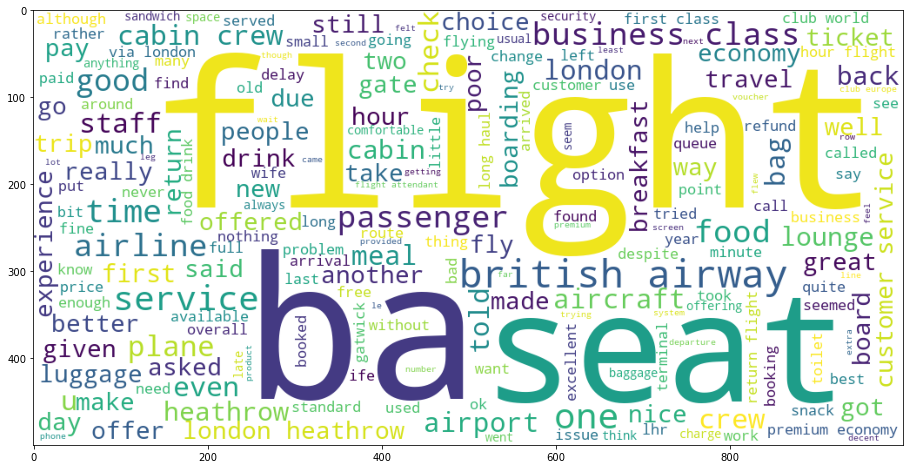

In [24]:
plt.rcParams['figure.figsize']= 20,8
plt.imshow(wordcloud)

In [25]:
len(corpus)

2000

## Topic modelling

In [26]:
#vectorisation using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()


Transforming the corpus into a sparse matrix using TF-IDF. The sparse matrix is technically a representation of the high dimensional text data. 

In [27]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)
tfidf

<2000x9156 sparse matrix of type '<class 'numpy.float64'>'
	with 137308 stored elements in Compressed Sparse Row format>

K-means clustering uses distances to cluster similar topics into the specified clusters, here k = 3. By analysing these clusters, we can extract valuable insights on commonly reviewed topics. 

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)

# fit the k-means model on the TF-IDF feature representation
kmeans.fit(tfidf)


KMeans(n_clusters=3)

In [33]:

# predict the cluster labels for each customer review
labels = kmeans.predict(tfidf)

from collections import Counter
label_count = Counter(labels)


for label, count in label_count.items():
    print(f"Label: {label}, Count: {count}")

Label: 1, Count: 772
Label: 2, Count: 494
Label: 0, Count: 734


In [34]:
top_words = {}

for label in np.unique(labels):
    indices = np.where(labels == label)[0]

    #to get the tfidf representation of the top words
    cluster_tfidf = tfidf[indices]

    feature_names = vectorizer.get_feature_names_out()

    mean = np.mean(cluster_tfidf,axis = 0)

    #sort the top scores
    sorted_mean = np.argsort(mean.A1)[-10:]

    top_words[label] = [feature_names[i] for i in sorted_mean]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


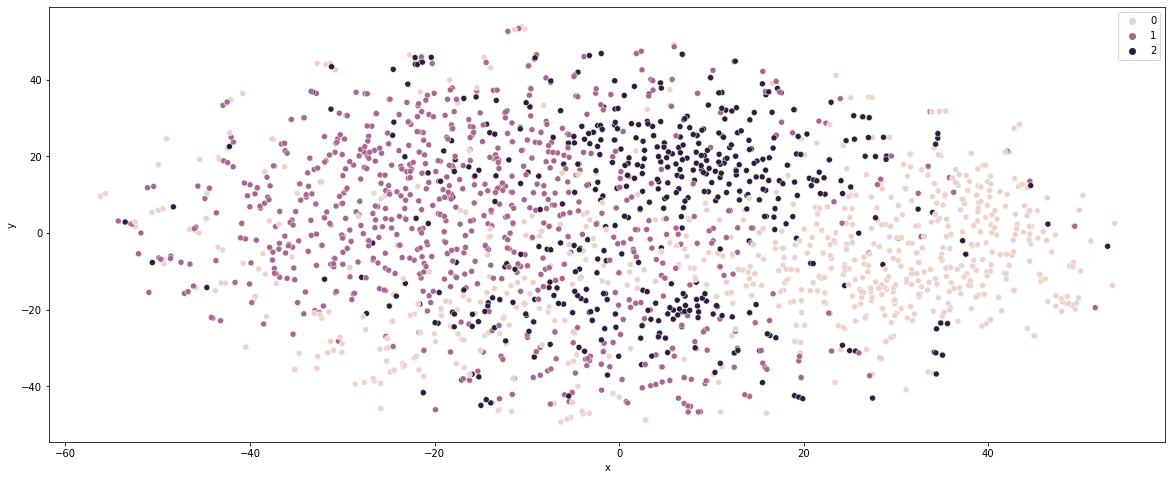

In [36]:
from sklearn.manifold import TSNE

embedding = TSNE(n_components=2)
Xp = embedding.fit_transform(tfidf)
df_projection = pd.DataFrame({'x': Xp[:, 0], 'y': Xp[:, 1]})
sns.scatterplot(x='x', y='y',hue= labels, data=df_projection)
plt.show()

In [37]:
total_count = sum(label_count.values())
for label, count in label_count.items():
    label_proportion = count/total_count
    print(f"label: {label}, proportion:{label_proportion}")


label: 1, proportion:0.386
label: 2, proportion:0.247
label: 0, proportion:0.367


From the K-means clustering done prior to t-SNE, we had obtained the labels for each cluster. in the t-SNE analysis, using dimensionality reduction we can transform vectorised corpus into scatter plot to visualise the clusters they belong to. 

the cluster labels are denoted on the top right corner. This analysis is unsupervised. The clusters 0 and 1 have the most number of points. The clusters consists of top words that point towards cabin, service, seats and cancellation of flights, baggage,ba, flight. 

In [38]:
top_words

{0: ['bag',
  'airline',
  'london',
  'service',
  'british',
  'airway',
  'customer',
  'hour',
  'ba',
  'flight'],
 1: ['london',
  'seat',
  'ba',
  'service',
  'time',
  'cabin',
  'food',
  'crew',
  'good',
  'flight'],
 2: ['premium',
  'service',
  'food',
  'airline',
  'flight',
  'economy',
  'ba',
  'business',
  'class',
  'seat']}

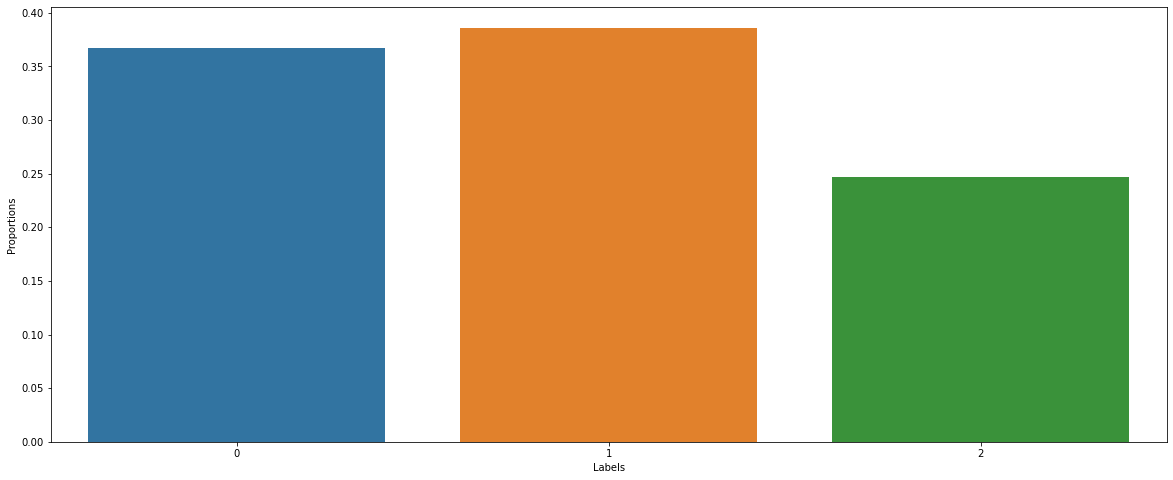

In [39]:
import seaborn as sns

total_count = sum(label_count.values())
label_proportions = {label: count/total_count for label, count in label_count.items()}

sns.barplot(x=list(label_proportions.keys()), y=list(label_proportions.values()))
plt.xlabel('Labels')
plt.ylabel('Proportions')
plt.show()


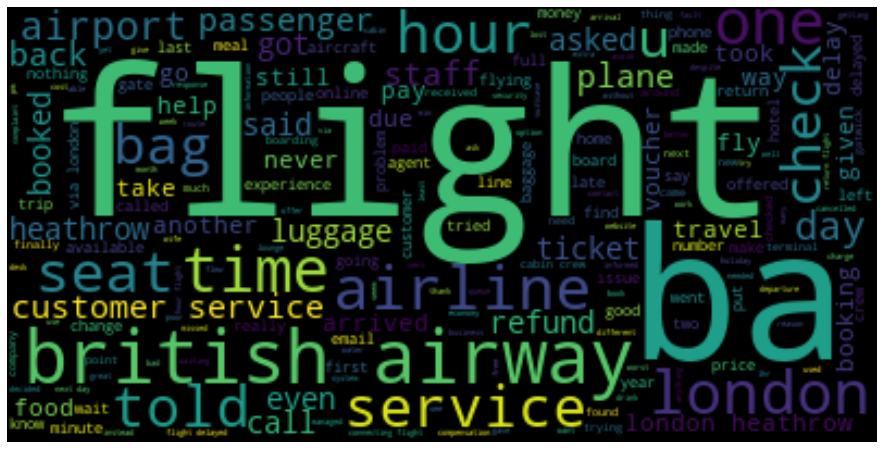

In [41]:
label4 = 0
label_texts = [text for text,l in zip(corpus,labels) if l == label4]

text = ' '.join(label_texts)

# create a word cloud
wordcloud = WordCloud().generate(text)

# plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

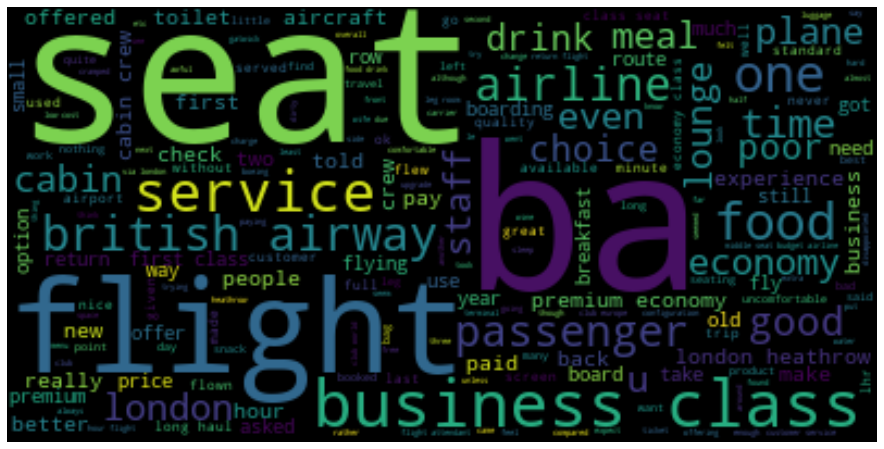

In [40]:
#to create a word cloud for the labels with the highest proportion
label2 = 2
label_texts = [text for text,l in zip(corpus,labels) if l == label2]

text = ' '.join(label_texts)

# create a word cloud
wordcloud = WordCloud().generate(text)

# plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

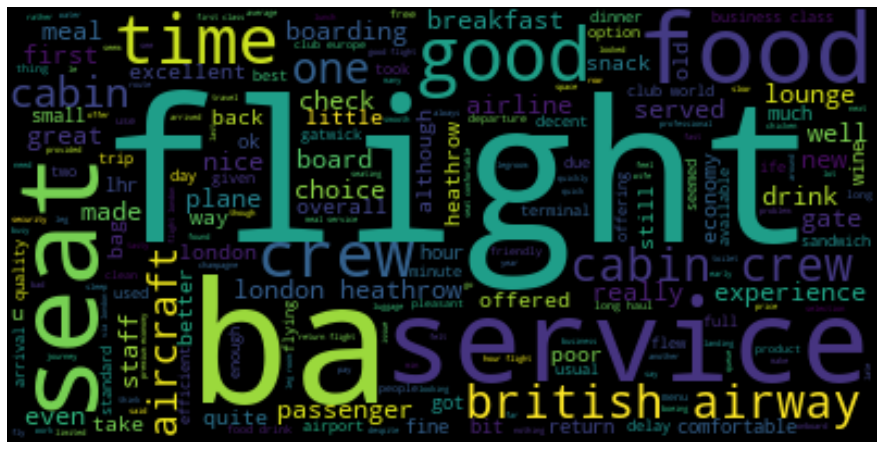

In [42]:
#to create a word cloud for the labels with the highest proportion
label1 = 1
label_texts = [text for text,l in zip(corpus,labels) if l == label1]

text = ' '.join(label_texts)

# create a word cloud
wordcloud = WordCloud().generate(text)

# plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The wordclouds for the 3 clusters are insightful. However, the word flight, british airway and ba are generic. It does not impart any knowledge as it is obvious that these words are the topics of discussion. 

In [43]:
stopwords = ["british airway","ba","flight"]
corpus = [" ".join([word for word in sentence.split() if word not in stopwords]) for sentence in corpus]

In [44]:
vectorizer3 = TfidfVectorizer()
tfidf3 = vectorizer3.fit_transform(corpus)
tfidf3

<2000x9154 sparse matrix of type '<class 'numpy.float64'>'
	with 134437 stored elements in Compressed Sparse Row format>

In [45]:
kmeans = KMeans(n_clusters=3)

# fit the k-means model on the TF-IDF feature representation
kmeans.fit(tfidf3)

# predict the cluster labels for each customer review
labels = kmeans.predict(tfidf3)

for label, count in label_count.items():
    print(f"Label: {label}, Count: {count}")

Label: 1, Count: 772
Label: 2, Count: 494
Label: 0, Count: 734


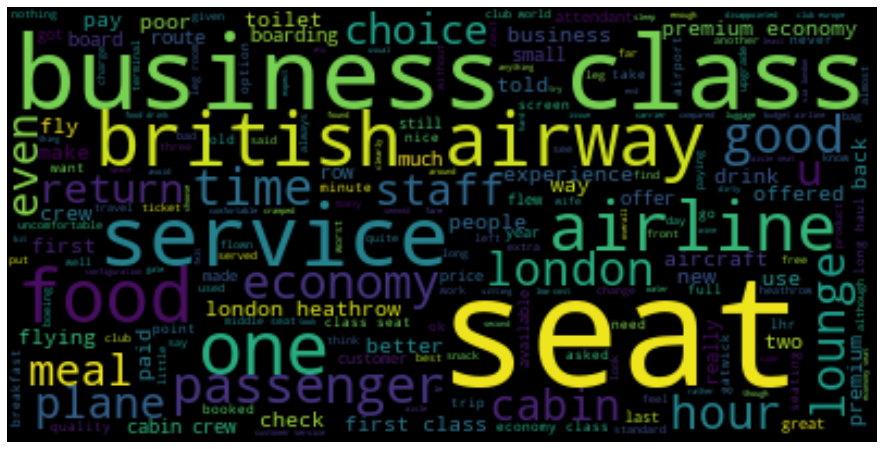

In [46]:
label2 = 2
label_texts = [text for text,l in zip(corpus,labels) if l == label2]

text = ' '.join(label_texts)

# create a word cloud
wordcloud = WordCloud().generate(text)

# plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

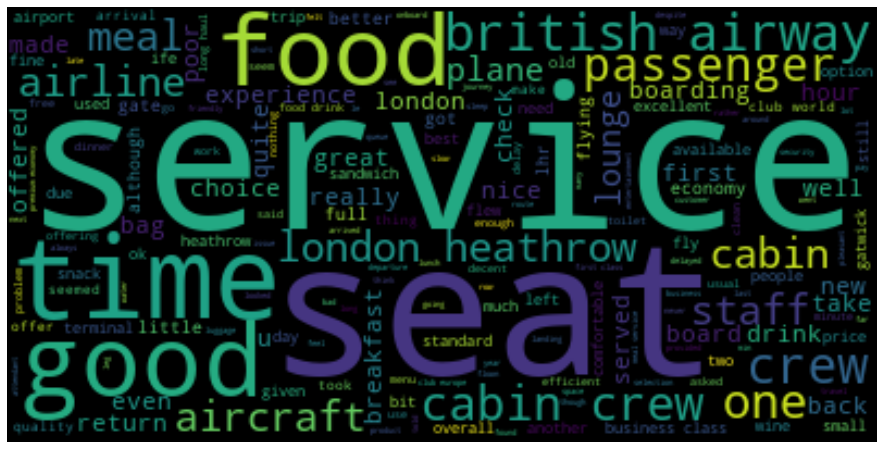

In [47]:
#to create a word cloud for the labels with the highest proportion
label1 = 1
label_texts = [text for text,l in zip(corpus,labels) if l == label1]

text = ' '.join(label_texts)

# create a word cloud
wordcloud = WordCloud().generate(text)

# plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

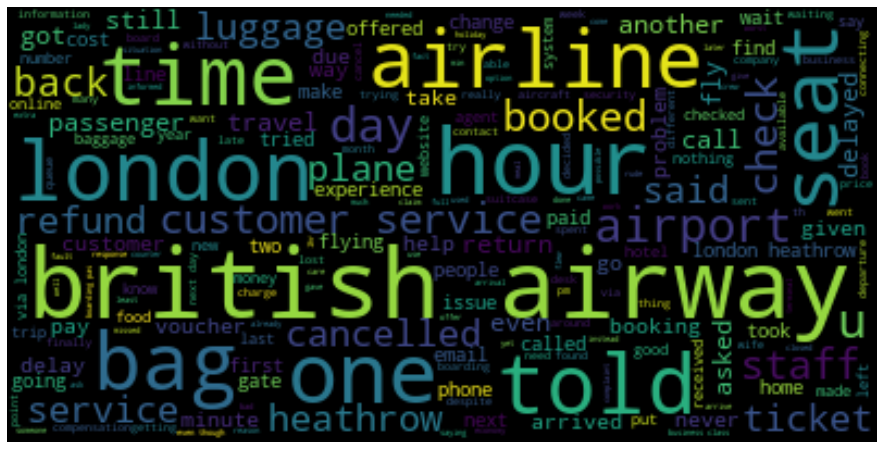

In [48]:
label4 = 0
label_texts = [text for text,l in zip(corpus,labels) if l == label4]

text = ' '.join(label_texts)

# create a word cloud
wordcloud = WordCloud().generate(text)

# plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()